In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import pickle
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'

# EDA

In [2]:
train = pd.read_csv('../../assets/data/train.csv')
train

,stan_nawodnienia,rodzaj_gleby,stan_nawiezienia,stopien_rozwoju,rodzaj_rosliny,rodzaj_nawozu,to_water
0,0.32,brunatne,0.01,0.75,ziemniak,mineralny,1
1,0.38,brunatne,0.15,0.85,pszenica,organiczny,1
2,0.17,piaszczyste,0.22,0.13,brak,organiczny,1
3,0.67,czarnoziemy,0.64,0.55,pszenica,sztuczny,0
4,0.45,brunatne,0.16,0.16,brak,organiczny,1
...,...,...,...,...,...,...,...
172,0.22,czarnoziemy,0.24,0.25,kaktus,organiczny,1
173,0.17,brunatne,0.31,0.35,ziemniak,mineralny,1
174,0.91,brunatne,0.58,0.89,ziemniak,sztuczny,0
175,0.07,brunatne,0.27,0.27,ziemniak,organiczny,1


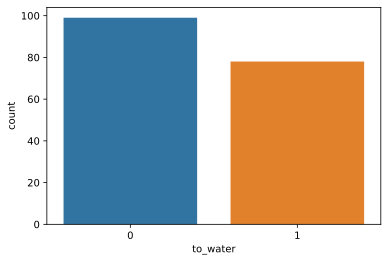

In [3]:
sns.countplot('to_water', data=train);

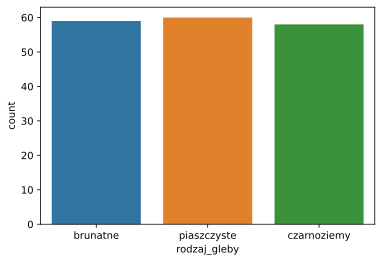

In [4]:
sns.countplot('rodzaj_gleby', data=train);

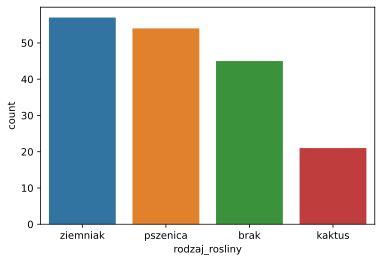

In [5]:
sns.countplot('rodzaj_rosliny', data=train);

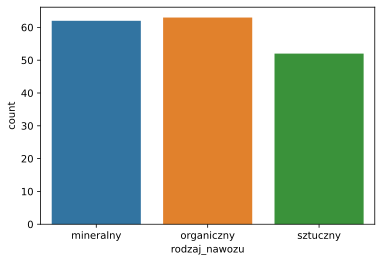

In [6]:
sns.countplot('rodzaj_nawozu', data=train);

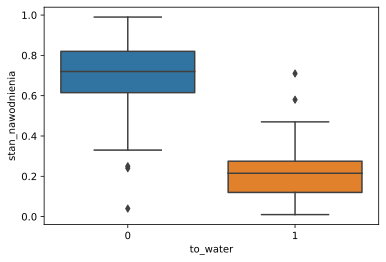

In [7]:
sns.boxplot(train.to_water, train.stan_nawodnienia);

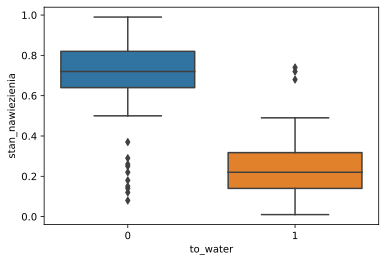

In [8]:
sns.boxplot(train.to_water, train.stan_nawiezienia);

# Features Engineering

In [10]:
train = pd.get_dummies(train)
train

,stan_nawodnienia,stan_nawiezienia,stopien_rozwoju,to_water,rodzaj_gleby_brunatne,rodzaj_gleby_czarnoziemy,rodzaj_gleby_piaszczyste,rodzaj_rosliny_brak,rodzaj_rosliny_kaktus,rodzaj_rosliny_pszenica,rodzaj_rosliny_ziemniak,rodzaj_nawozu_mineralny,rodzaj_nawozu_organiczny,rodzaj_nawozu_sztuczny
0,0.32,0.01,0.75,1,1,0,0,0,0,0,1,1,0,0
1,0.38,0.15,0.85,1,1,0,0,0,0,1,0,0,1,0
2,0.17,0.22,0.13,1,0,0,1,1,0,0,0,0,1,0
3,0.67,0.64,0.55,0,0,1,0,0,0,1,0,0,0,1
4,0.45,0.16,0.16,1,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.22,0.24,0.25,1,0,1,0,0,1,0,0,0,1,0
173,0.17,0.31,0.35,1,1,0,0,0,0,0,1,1,0,0
174,0.91,0.58,0.89,0,1,0,0,0,0,0,1,0,0,1
175,0.07,0.27,0.27,1,1,0,0,0,0,0,1,0,1,0


In [11]:
X_train = train.drop('to_water', axis=1)
y_train = train['to_water']

# Training XGBoost model

In [12]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
def cv_model(X_train, y_train, model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'precision': 'precision_macro',
               'recall': 'recall_macro',
               'accuracy': 'accuracy',
               'auc': 'roc_auc'}
    cv_results = []
    
    cv_model = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold)
    cv_results.append([cv_model['test_precision'].mean(), cv_model['test_recall'].mean(),
                       cv_model['test_accuracy'].mean(), cv_model['test_auc'].mean()])
    
    return cv_results

def show_cv_results(cv_results):
    cvr_df = pd.DataFrame(index=['XGBoost'],
                          data=cv_results, columns=['precision', 'recall', 'accuracy', 'AUC'])
    return cvr_df

In [14]:
cv_results = cv_model(X_train, y_train, xgb)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
XGBoost,0.924244,0.920625,0.920952,0.973928


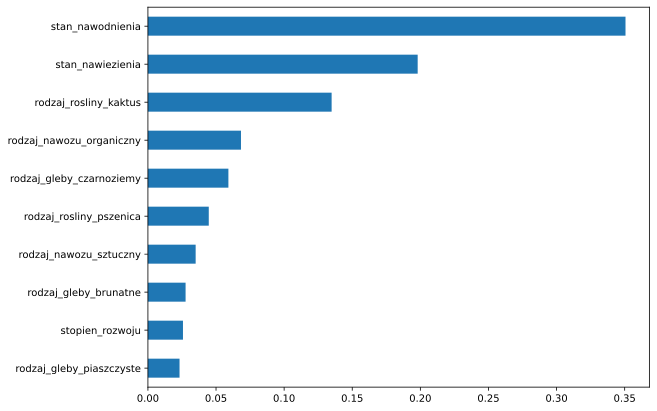

In [15]:
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 7]);

# XGBoost parameter tuning using HyperOpt

In [16]:
params_bounds = {'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
                 'n_estimators': hp.uniform('n_estimators', 100.0, 1000.0),
                 'max_depth': hp.uniform('max_depth', 4.0, 10.0), 
                 'subsample': hp.uniform('subsample', 0.5, 1.0),
                 'gamma': hp.uniform('gamma', 0.0, 5.0)}

In [17]:
def fun(params_bounds):
    model = XGBClassifier(eval_metric='mlogloss',
                          learning_rate = params_bounds['learning_rate'],
                          n_estimators = round(params_bounds['n_estimators']),
                          max_depth = round(params_bounds['max_depth']),
                          subsample = params_bounds['subsample'],
                          gamma = params_bounds['gamma'])
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [18]:
trials = Trials()
best = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)
best['max_depth'] = round(best['max_depth'])
best['n_estimators'] = round(best['n_estimators'])
best

100%|███████████████████████████████████████████████| 30/30 [00:20<00:00,  1.47trial/s, best loss: -0.9791677631578948]


{'gamma': 2.877864670923052,
 'learning_rate': 0.01623819939058474,
 'max_depth': 6,
 'n_estimators': 378,
 'subsample': 0.8352886879422001}

In [19]:
xgb = XGBClassifier(eval_metric='mlogloss', **best)
xgb.fit(X_train, y_train)
cv_results = cv_model(X_train, y_train, xgb)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
XGBoost,0.936778,0.930734,0.932063,0.975984


**As expected, no improvement at all**

# Testing Model

In [20]:
test = pd.read_csv('../../assets/data/test.csv')
test = pd.get_dummies(test)

In [21]:
X_test = test.drop('to_water', axis=1)
y_test = test['to_water']

In [22]:
prediction = xgb.predict(X_test)

In [23]:
data=[[precision_score(y_test, prediction),
       recall_score(y_test, prediction),
       accuracy_score(y_test, prediction),
       roc_auc_score(y_test, prediction)]]
result_df = pd.DataFrame(index=['XGBoost'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC'])
result_df

,precision,recall,accuracy,AUC
XGBoost,1.0,0.916667,0.972222,0.958333


In [24]:
y_test[y_test != prediction]

34    1
Name: to_water, dtype: int64

**Only one wrong prediction:**

In [25]:
X_test.iloc[34]

stan_nawodnienia            0.34
stan_nawiezienia            0.72
stopien_rozwoju             0.53
rodzaj_gleby_brunatne       0.00
rodzaj_gleby_czarnoziemy    0.00
rodzaj_gleby_piaszczyste    1.00
rodzaj_rosliny_brak         0.00
rodzaj_rosliny_kaktus       0.00
rodzaj_rosliny_pszenica     1.00
rodzaj_rosliny_ziemniak     0.00
rodzaj_nawozu_mineralny     1.00
rodzaj_nawozu_organiczny    0.00
rodzaj_nawozu_sztuczny      0.00
Name: 34, dtype: float64

# Save XGBoost model using pickle

In [26]:
filename = '../../assets/model/xgboost_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))